# Filter data

We calculate colony growth rate of Staph-Pseudomonas co-cultures on agar-pads and perform some filtering steps

Note: SA1 is GFP strain / SA2 is RFP strain

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
#%matplotlib widget
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#path handling
import pathlib

--- 

## 1. Load data

In [2]:
#set path to output csv files
path_data_files = pathlib.Path() 

#set filenames
data_name = "20230411"

#read data
csv_name = path_data_files / f"{data_name}_all_data.csv"
df_all = pd.read_csv(csv_name, index_col=0)

#set settings
dt_frames = 3/60 #time between frames in hours 

---

## 2. Pre-process data 

We do some clean up by:

- removing PA data from data frame, as we only care about SA growth. 
- removing untracked colonies
- remove colonies close to frame edge

We add some new fields to data frame:

- `unique_id`: a unique ID for each colony by combining strain with position number and with colony_id
- `log_norm_area`: to compare growth between colonies we first normalize colony area to 1 in the first frame and than take the log of this (colony grow exponentially in area)
- `genotype` : genotype of SA of strain
- `marker`: color marker of SA strain
- `media`: growth media of experiment 
- `community`: specifies combination of marker and genotype

We then plot the log normalized area as function of time.

In [3]:
def parse_conditon(x):

    SA1genotype = x['condition'].split('GFP')[0].split('_')[-1]
    SA2genotype = x['condition'].split('RFP')[0].split('_')[-1]
    media = x['condition'].split('_')[-1]
    
    d = {}
    d['media'] = media
    d['community'] = x.condition.split('_PA')[0]
    
    if x['strain']=='SA1':
        d['genotype'] = SA1genotype
        d['marker'] = 'GFP'
    elif x['strain']=='SA2':
        d['genotype'] = SA2genotype
        d['marker'] = 'RFP'
    elif x['strain']=='PAO1':
        d['genotype'] = 'PAO1'
        d['marker'] = 'NA'
    else:
        d['genotype'] = 'NA'
        d['marker'] = 'NA'
        
    index = ['genotype', 'marker', 'media','community']    
        
    return pd.Series(d, index=index)


#filter out PA and untracked colonies
df = df_all.loc[(~(df_all['strain']=='PA')) & (df_all['colony_id']>=0)].copy()

#add unique id
unique_id = df['strain'].map(str) + '-' + df['pos'].map(str) + '-' + df['colony_id'].map(str)  
df['unique_id'] = unique_id

#add time in hours
df['time'] = df['frame']*dt_frames

# add normalized area
df['area'] = df['area'].astype(float)
df['lognorm_area'] = np.log(df['area'].div(df.groupby('unique_id')['area'].transform('first')))
df['log_area_change'] = df.groupby('unique_id')['lognorm_area'].diff(1)


#add parsed condition
df = pd.concat([df, df.apply(parse_conditon, axis=1)], axis=1)

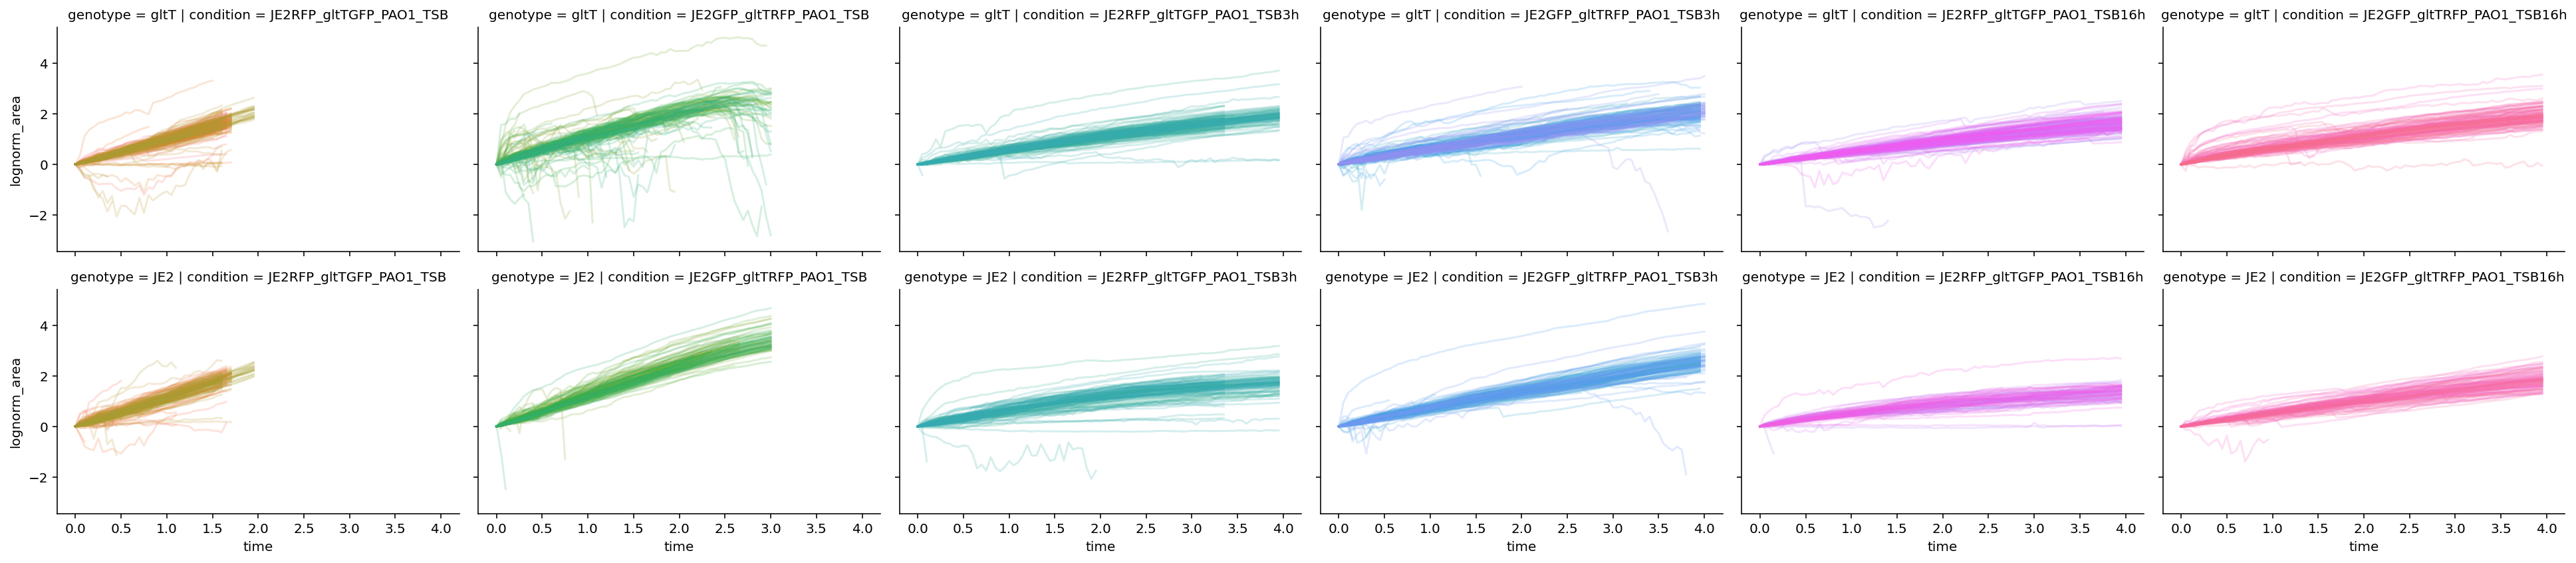

In [4]:
#plot log normalized area
g = sns.FacetGrid(data=df, col='condition',row='genotype',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='time', y='lognorm_area', alpha=0.2)

### Filter out miss-tracked colonies

We see there are some weird trajectories which we need to remove.

We do automatic filtering by calculate the log length change between two frames and cutting trajectories when this becomes too big or small

(-0.2, 0.3)

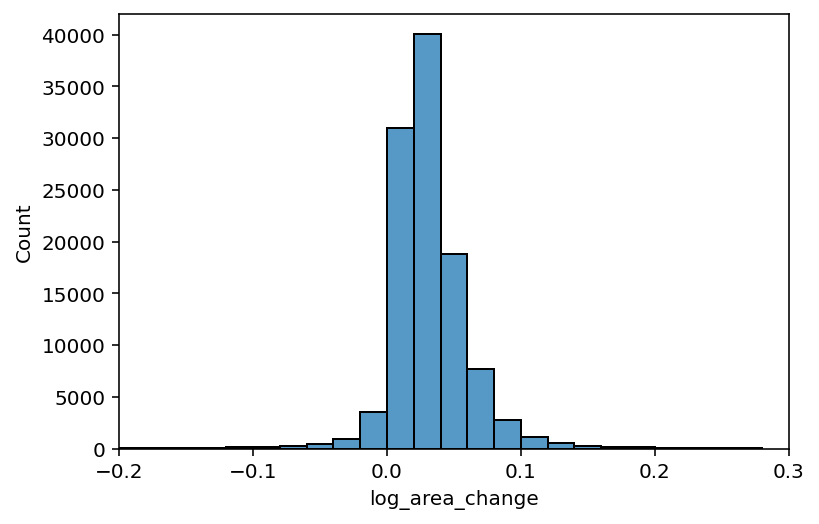

In [5]:
sns.histplot(data=df, x='log_area_change', bins=np.arange(-0.2,0.3,0.02)).set_xlim(-0.2,0.3)

Based on histogram we can set max change in length (corresponds to max growth rate) and plot the resulting filtered data

In [6]:
print(df['log_area_change'].describe())
print(np.nanquantile(df['log_area_change'],[0.01,0.025,0.975,0.99]))

count    108616.000000
mean          0.030732
std           0.050832
min          -3.330715
25%           0.016250
50%           0.026864
75%           0.043745
max           1.821087
Name: log_area_change, dtype: float64
[-0.05625966 -0.01561324  0.09895918  0.13261584]


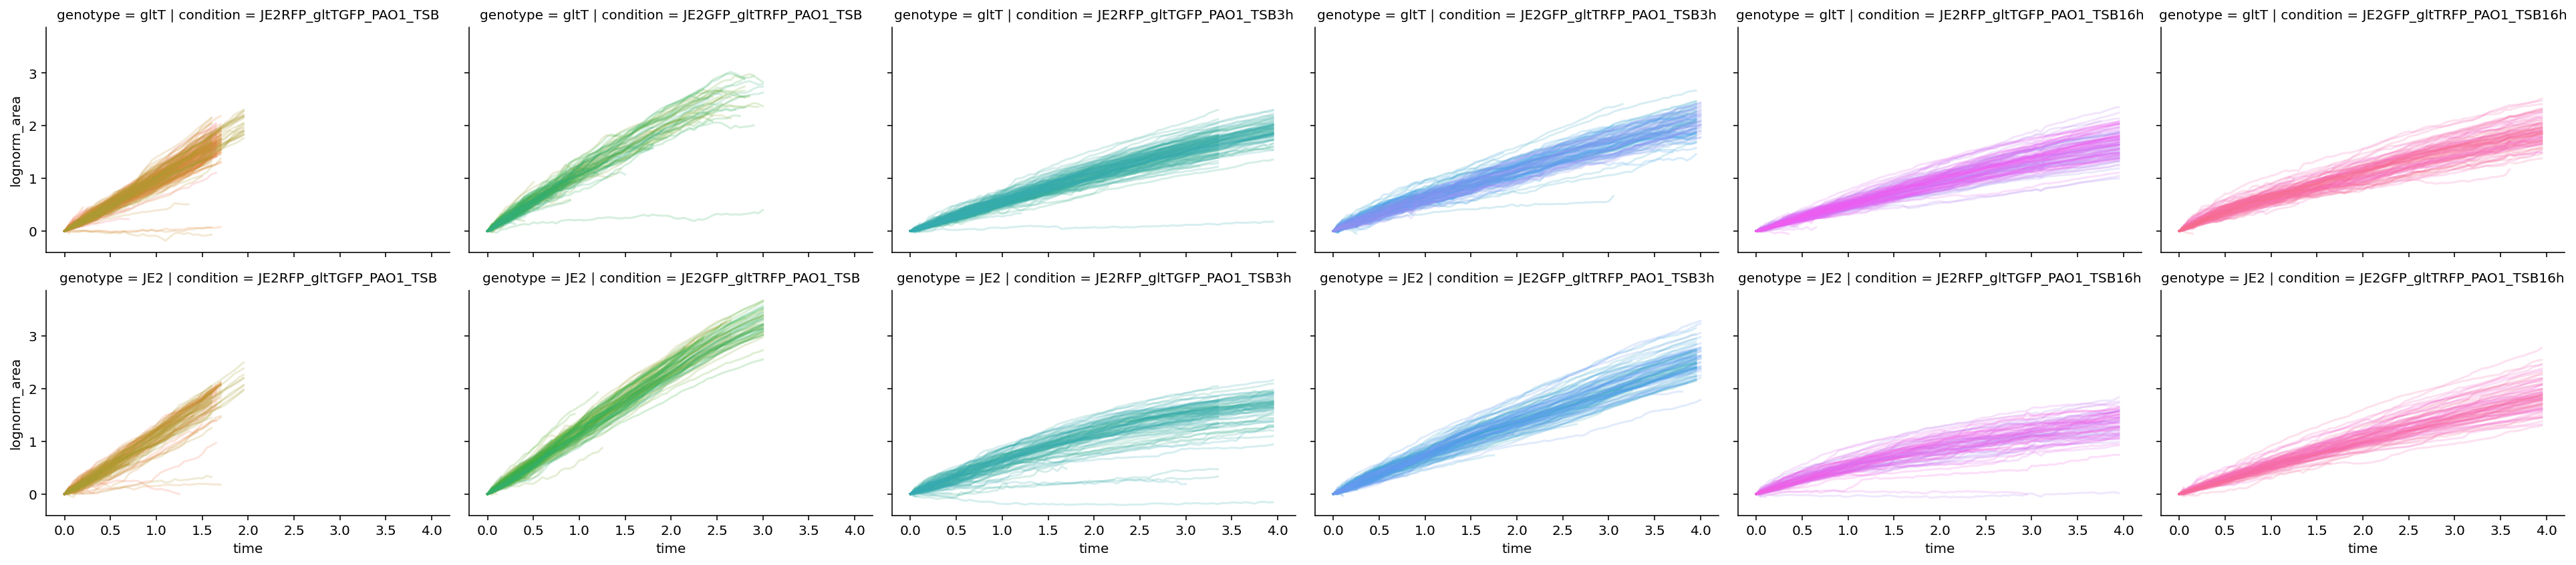

In [7]:
#set min and max change in log area between frames for filtering
min_dl = -0.06
max_dl = 0.14

#stop tracks at first frame where error occurs
df['track_error'] = (df['log_area_change']<min_dl) | (df['log_area_change']>max_dl)
track_filter = df.groupby('unique_id')['track_error'].cumsum() > 0
df_filtered = df.loc[~track_filter].copy()

df_filtered.to_csv(path_data_files / f"{data_name}_filtered_data.csv")

#plot filtered data
g = sns.FacetGrid(data=df_filtered, col='condition',row='genotype',aspect=1.5,hue='unique_id')
g.map_dataframe(sns.lineplot, x='time', y='lognorm_area', alpha=0.2)

Let's check how many colonies we can track as function of time:

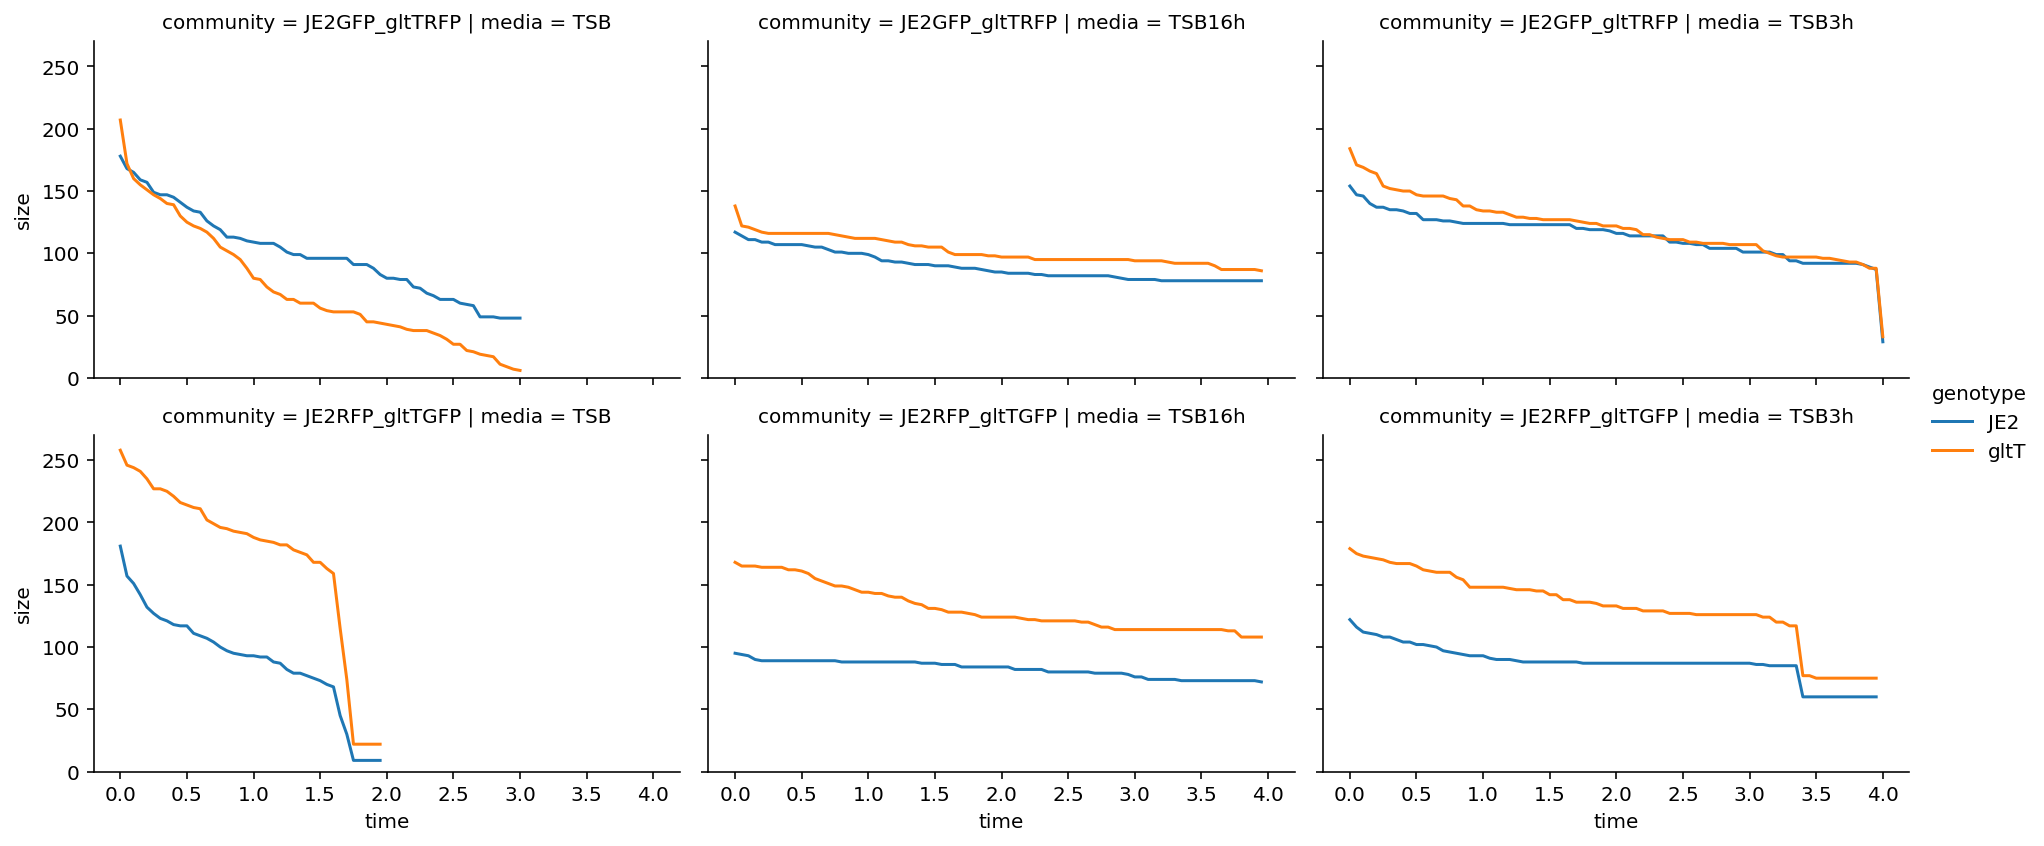

In [8]:
col_num_t = df_filtered.groupby(['community','media','genotype','frame','time','condition'], as_index=False).size()
g = sns.FacetGrid(data=col_num_t, row='community',col='media',hue='genotype',aspect=1.5)
g.map_dataframe(sns.lineplot, x='time', y='size').add_legend()
g.set(ylim=(0, None))